In [ ]:
from bs4 import BeautifulSoup
import requests
import warnings
import random
import string
import time

warnings.filterwarnings('ignore')

TIMEOUT = 5
CNET_BASE_URL = 'https://www.cnet.com'

def fetch_webpage(url, retry_count=5):
    html = None
    while not html and retry_count > 0:
        try:
            html = requests.get(url, verify=False, timeout=TIMEOUT).content
        except requests.exceptions.RequestException:
            print('Could not connect to {}. Retry count: {}'.format(url, retry_count))
            retry_count -= 1
    return html

def get_review_links(html):
    soup = BeautifulSoup(html, 'lxml')
    links = [(p.select('.itemInfo h3')[0].get_text(), 
              CNET_BASE_URL+p.select('a.imageWrap')[0]['href']) 
             for p in soup.select('section.product')]
    #links = [CNET_BASE_URL + a['href'] 
    #         for a in soup.select('section.product a.imageWrap')]
    return links

def get_review_page(html):
    soup = BeautifulSoup(html, 'lxml')
    [s.extract() for s in soup(['script', 'figure'])]
    text = soup.find_all(['p', 'ul'], attrs={'class': None})
    #text = soup.select('#editorReview > p, #editorReview > ul > li')
    text = None if len(text) == 0 else '\n\n'.join(['\n'.join(t.strings) for t in text])
    next_page = soup.select('a.nextPage')
    next_page = None if len(next_page) == 0 or next_page[0]['rel'][0] == 'prev' else CNET_BASE_URL + next_page[0]['href']
    return text, next_page

def get_full_review(first_page_url):
    full_review = ''
    review_title = BeautifulSoup(fetch_webpage(first_page_url))
    review_title = review_title.select('.headline')
    if len(review_title) > 0:
        review_title = review_title[0]
        review_title = review_title.get_text().strip()
    else:
        review_title = 'NO TITLE [{}]'.format(uuid())
    next_page = first_page_url
    while next_page:
        html = fetch_webpage(next_page)
        text, next_page = get_review_page(html)
        full_review += '\n\n' + (text if text else '')
    return full_review, review_title
        
def uuid():
    return ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

reviews = {}
html = fetch_webpage('https://www.cnet.com/topics/smart-home/products/')
links = get_review_links(html)
print('Page: 1')
for link in links:
    review, key = get_full_review(link[1])
    if key in reviews:
        key = key + ' ({})'.format(uuid())
    reviews[key] = (link, review)
    time.sleep(1)
"""    
for i in range(2, 158):
    print('Page:', i)
    html = fetch_webpage('https://www.cnet.com/topics/smart-home/products/{}/'.format(i))
    links = get_review_links(html)
    for link in links:
        review, key = get_full_review(link[1])
        if key in reviews:
            key = key + ' ({})'.format(uuid())
        reviews[key] = (link, review)
        time.sleep(1)
"""

In [ ]:
print(reviews)

In [ ]:
import pickle

with open('cnet-reviews.pickle', 'wb') as f:
    pickle.dump(reviews, f)

In [ ]:
import pickle

with open('cnet-reviews.pickle', 'rb') as f:
    reviews = pickle.load(f)

In [ ]:
import csv

with open('cnet.csv', 'w') as f:
    writer = csv.writer(f, delimiter='|')
    for k,v in reviews.items():
        writer.writerow([v[0][0], v[0][1], k, v[1]])

In [ ]:
sample_reviews = {}
keys = list(reviews.keys())
for i in range(0, 628, 13):
    sample_reviews[keys[i]] = reviews[keys[i]]

# Analysis

In [3]:
import pandas as pd
import analyze_text as atxt
%matplotlib inline

# Prepare text
df = pd.read_csv('cnet-classifications.csv')
df['labels_factor'] = pd.factorize(df['device_category'])[0]
all_sil_scores = {}

In [2]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary.load('cnet-65_dictionary.gensim')
ldamodel = LdaModel.load('cnet-65_model.gensim')

In [ ]:
# LDA
NUM_TOPICS = 65

texts_tokens = [atxt.prepare_text_for_lda(text) 
                for text in df['article_content']]
ldamodel = atxt.run_lda(texts_tokens, 
             dictionary_save_name='cnet-{}_dictionary.gensim'.format(NUM_TOPICS),
             corpus_save_name='cnet-{}_corpus.pkl'.format(NUM_TOPICS), 
             model_save_name='cnet-{}_model.gensim'.format(NUM_TOPICS), 
             num_topics=NUM_TOPICS,
             print_topics=False)

In [5]:
# HDP
from gensim.models.hdpmodel import HdpModel
from gensim import corpora

texts_tokens = [atxt.prepare_text_for_lda(text) 
                for text in df['article_content']]
dictionary = corpora.Dictionary(texts_tokens)
corpus = [dictionary.doc2bow(text) for text in texts_tokens]
hdpmodel = HdpModel(corpus, dictionary)

In [10]:
shown_topics = hdpmodel.show_topics(formatted=False)
topics_nos = [x[0] for x in shown_topics]
weights = [sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos]
pd.DataFrame({'topic_id':topics_nos, 'weight':weights}).sort_values(by='weight')

    topic_id    weight
14        14  0.027812
19        19  0.028298
17        17  0.029310
13        13  0.029769
10        10  0.030033
15        15  0.030426
18        18  0.030643
12        12  0.030786
16        16  0.031535
11        11  0.039028
9          9  0.040408
7          7  0.045678
8          8  0.047940
6          6  0.048055
4          4  0.050276
5          5  0.057507
3          3  0.064979
2          2  0.085463
1          1  0.114114
0          0  0.130579

In [ ]:
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import seaborn as sb
import math
import textwrap

NUM_SAMPLES = 25
fig, ax = plt.subplots(5, 5, figsize=(25, 15))

dictionary = Dictionary.load('cnet-65_dictionary.gensim')
df_sample = df.sample(n=NUM_SAMPLES).reset_index()
for i, row in df_sample.iterrows():
    data = []
    prepared_text = atxt.prepare_text_for_lda(row['article_content'])
    #print(row['device_name'])
    #print(prepared_text)
    docbow = dictionary.doc2bow(prepared_text)
    topics = ldamodel.get_document_topics(docbow)
    for topic_id, score in topics:
        terms = ldamodel.get_topic_terms(topic_id, topn=3)
        label = '\n'.join([dictionary.get(t) for t,_ in terms])
        data.insert(0, {'label': label, 'score': score})
        #print(label.replace('\n', ';'), topic_id)
    #print('-----')
    plt_df = pd.DataFrame(data).sort_values('score', ascending=False)
    ax_x = math.floor(i / math.sqrt(NUM_SAMPLES))
    ax_y = math.floor(i % math.sqrt(NUM_SAMPLES))
    barplot = sb.barplot(x='label', y='score', data=plt_df,
                         ax=ax[ax_x, ax_y], ci=None)
    ax[ax_x, ax_y].set_title(textwrap.fill(row['device_name'] + ' ({})'.format(row['device_category'], 15)))
    plt.tight_layout()

In [ ]:
from collections import defaultdict

counts = defaultdict(lambda: 0)
num_topics = {}
for i, row in df.iterrows():
    prepared_text = atxt.prepare_text_for_lda(row['article_content'])
    docbow = dictionary.doc2bow(prepared_text)
    topics = ldamodel.get_document_topics(docbow)
    n_t = 0
    for topic_id, score in topics:
        if score > 0.2:
            counts[topic_id] += 1
            n_t += 1
    num_topics[i] = n_t

In [ ]:
plt.figure(figsize=(20, 10))

counts_df = pd.DataFrame(list(counts.items()))
counts_df.columns = ['id', 'count']
counts_df['label'] = counts_df['id'].apply(lambda i: ', '.join([dictionary.get(t) for t,_ in ldamodel.get_topic_terms(i, topn=3)]))
#counts_df['id'] = counts_df['id'].apply(lambda i: '"'+str(i)+'"')
counts_df = counts_df.sort_values('count', ascending=False)
sb.barplot(data=counts_df, x='label', y='count', ci=None)

plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(15, 5))
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')

counts_df = pd.DataFrame(list(num_topics.items()))
counts_df.columns = ['id', 'count']
counts_df['label'] = counts_df['id'].apply(lambda i: df.iloc[i]['device_name'])
counts_df['id'] = counts_df['id'].apply(lambda i: '"'+str(i)+'"')
counts_df = counts_df.sort_values('count', ascending=False)
sb.barplot(data=counts_df, x='label', y='count', ci=None)

plt.tight_layout()

counts_df.head(10)

In [ ]:
prepared_text = atxt.prepare_text_for_lda(df.iloc[424]['article_content'])
print(prepared_text)
docbow = dictionary.doc2bow(prepared_text)
topics = ldamodel.get_document_topics(docbow)
for t, s in topics:
    print(s)
    [print(dictionary.get(t)) for t,_ in ldamodel.get_topic_terms(t, topn=3)]
    print('----')

In [ ]:
[print(dictionary.get(t)) for t,_ in ldamodel.get_topic_terms(50)]

In [11]:
# TF-IDF
texts = [tuple(r) for r in df[['device_name', 'article_content', 'labels_factor']].values]
feature_names, feature_indices, tfidf_scores, tfidf_matrix, tfidf_kmeans, tfidf_sph_kmeans = atxt.run_tfidf(texts, num_clusters=65, rand_score=False, draw_graph=False, max_df=1.0)

ValueError: not enough values to unpack (expected 6, got 5)

In [13]:
tfidf_scores = {k:list(v) for k,v in tfidf_scores.items()}

In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sb
import math
import textwrap

NUM_SAMPLES = 25
fig, ax = plt.subplots(5, 5, figsize=(25, 15))
sorted_tfidf = {k: sorted(v, key=lambda x: x[1], reverse=True)[0:5] for k,v in tfidf_scores.items()}

for i, (k, v) in enumerate(random.sample(sorted_tfidf.items(), NUM_SAMPLES)):
    data = []
    for word_id, score in v:
        word = feature_names[word_id]
        data.insert(0, {'word': word, 'score': score})
    plt_df = pd.DataFrame(data).sort_values('score', ascending=False)
    ax_x = math.floor(i / math.sqrt(NUM_SAMPLES))
    ax_y = math.floor(i % math.sqrt(NUM_SAMPLES))
    barplot = sb.barplot(x='word', y='score', data=plt_df, ax=ax[ax_x, ax_y],
                         ci=None)
    ax[ax_x, ax_y].set_title(textwrap.fill(df.iloc[k]['device_name'] + ' ({})'.format(df.iloc[k]['device_category'], 40)))
    plt.tight_layout()

In [15]:
import numpy as np
from IPython.display import display

df['cluster'] = tfidf_kmeans.labels_
km_list = []
for num, devices in df.groupby('cluster'):
    km_list.insert(0, {'cluster': num, 'text': '\n\n'.join(list(devices['article_content']))})
    print('Cluster number '+str(num))
    with pd.option_context('display.colheader_justify', 'left'):
        display(devices[['device_name', 'device_category']])
    print()

Cluster number 0


,device_name,device_category
120,Zmodo Torch Pro,camera
232,Kuna Toucan,camera
247,Bosch Eyes Outdoor Camera,camera
294,Kuna Light Fixture,light bulb
582,Sonne Industries Light Sentry,light bulb



Cluster number 1


,device_name,device_category
31,Cree 100W Replacement BR30 Floodlight LED,light bulb
101,Hyperikon 60W Equivalent LED,light bulb
133,GE 60W Equivalent HD Light LED,light bulb
310,Philips 40W Equivalent Candelabra LED,light bulb
311,Cree TW Series 40W Equivalent Candelabra LED,light bulb
375,Walmart Great Value 10W LED Light Bulb60W Equi...,light bulb
432,Finally Light Bulb,light bulb
434,Cree BR30 LED2015,light bulb
476,Green Creative BR30 Cloud LED,light bulb
535,GE Link Connected LED,light bulb



Cluster number 2


,device_name,device_category
61,Swidget Outlet,outlet
71,Shortcut Labs Flic Hub,smart button
74,Cnct IntelliPlug,outlet
80,Ambi Climate 2,AC
87,"Belkin WeMo Bridge, HomeKit-enabled",bridge
110,Geeni Energi,outlet
140,Belkin WeMo Mini Wi-Fi Smart Plug,outlet
213,Securifi Almond 3 Smart Home WiFi System,router
216,Shortcut Labs FlicSingle Smart Button,smart button
279,Cane Wireless Cliki,smart button



Cluster number 3


,device_name,device_category
2,Kwikset Obsidian Keywayless Smart Lock,smart lock
17,igloohome Smart Deadbolt 02,smart lock
45,Otto Smart Lock,smart lock
123,Kwikset Convert Smart Lock Conversion Kit,smart lock
128,Yale Assure Keyless Bluetooth Smart Lock,smart lock
200,Kwikset Premis,smart lock
217,Kwikset Kevo 2nd Gen Bluetooth Smart Lock,smart lock
229,Smart Armor Smart Cube,smart lock
344,Brinks Array,smart lock
399,Yale Linus Lock,smart lock



Cluster number 4


,device_name,device_category
10,Cherry Labs Cherry Home,security system
35,Tend Secure Lynx Solar Outdoor Camera,camera
94,Lighthouse Interactive Assistant,camera
177,Netatmo Smart Smoke Alarm,air hazard
220,Netatmo Presence,camera
403,Angee,camera
410,Netatmo Wind Gauge,weather station
437,Netatmo Welcome,camera
573,Netatmo Weather Station,weather station



Cluster number 5


,device_name,device_category
88,Olive & Dove RemoCam,camera
130,Ezviz Mini 360 Plus,camera
223,Ezviz Mini Plus,camera
241,People Power Presence 360,security system
333,Zmodo Pivot,camera
347,Ezviz Mini IQ,camera
348,Ezviz Mini Cube,camera
394,Ezviz Mini,camera



Cluster number 6


,device_name,device_category
23,Lifx Beam,light bulb
30,Lifx Mini Wi-Fi Smart Bulb,light bulb
34,Wiz Color Wi-Fi Smart LED Starter Kit,light bulb
53,Sylvania Smart Multicolor LED,light bulb
58,Oomi Home Starter Kit,starter kit
117,Philips Hue White and Color Ambiance Candle,light bulb
135,TP-Link LB130 Multicolor Wi-Fi LED,light bulb
203,Lifx Z Wi-Fi LED Light Strip Starter Kit,light bulb
204,Lifx Plus Wi-Fi LED Smart Bulb,light bulb
233,Lifx White 900 BR30 Wi-Fi LED Smart Bulb,light bulb



Cluster number 7


,device_name,device_category
131,Brilliant Control,light switch
218,Big Ass Solutions Haiku Smart Ceiling Light,light bulb
236,LuDela Smart Candle,light bulb
364,Big Ass Solutions Haiku L Series Ceiling Fan,fan
575,Big Ass Fans Haiku Ceiling Fan with SenseME,fan



Cluster number 8


,device_name,device_category
495,BOT Home Automation Ring,doorbell
556,BOT Home Automation Doorbot,doorbell



Cluster number 9


,device_name,device_category
42,Haier Link Cook Series,refrigerator
114,Sense Home Energy Monitor,energy monitor
142,Curb Whole-Home Energy Monitoring,energy monitor
326,Orison Panel,energy storage
338,Spün Utensil,kitchen
422,SunPort,outlet
433,Neurio Home Intelligence,energy monitor



Cluster number 10


,device_name,device_category
55,SimpliSafe SimpliCam,camera
349,SimpliSafe Security Camera,camera
387,Korner,security system
496,Scout Home Security System,security system
592,Iris Home Management System,hub
606,SimpliSafe Home Security,security system
611,Viper Home,security system



Cluster number 11


,device_name,device_category
25,Samsung SmartThings ADT Home Security Starter Kit,security system
64,Intellithings RoomMe,motion sensor
76,Hive Welcome Home Standard,starter kit
209,Samsung SmartThings Water Leak Sensor,leak detector
280,Knocki,gesture controller
295,Iris by Lowe's Second Generation,starter kit
405,SmartThings Hub and Sensors,starter kit
435,AllBe1,security system
460,Staples Connect HubD-Link Edition,hub
479,Wink Relay,hub



Cluster number 12


,device_name,device_category
100,Nomiku Sous Chef,kitchen
318,BrewJacket Immersion Pro,kitchen
463,Anova Precision Cooker,kitchen



Cluster number 13


,device_name,device_category
5,Noon Smart Lighting Starter Kit,light bulb
50,iDevices Dimmer Switch,light switch
63,Leviton Decora Smart Dimmer with HomeKit,light switch
83,Belkin WeMo Dimmer Wi-Fi Light Switch,light switch
112,iDevices Wall Outlet,outlet
168,Incipio CommandKit Wi-Fi Switch,light switch
169,Incipio CommandKit Wi-Fi Power Strip,outlet
194,iDevices Instant Switch,light switch
206,Lutron Caseta In-Wall Wireless Smart Lighting Kit,light switch
262,iDevices Socket,light bulb



Cluster number 14


,device_name,device_category
28,Blossom Smart Watering Controller,sprinkler
49,Orbit B-hyve,sprinkler
57,Rachio Smart Sprinkler Controller Generation 2,sprinkler
308,Blossom 8 Smart Watering Controller,sprinkler
374,Etwater,sprinkler
423,Mist Labs Mist Sprinkler System,sprinkler
452,GreenIQ Smart Garden Hub,garden monitor
550,Plaid Systems Eve Ecosystem,garden monitor
587,Rachio Iro,sprinkler



Cluster number 15


,device_name,device_category
36,Nest Thermostat E,thermostat
59,Lennox iComfort E30 Smart Thermostat,thermostat
90,Emerson Sensi Touch Wi-Fi Thermostat,thermostat
98,Ecobee4 Smart Thermostat,thermostat
226,Ecobee3 Lite Smart Thermostat,thermostat
230,Emerson Sensi Wi-Fi Programmable Thermostat,thermostat
243,Emerson 1F78-151 Thermostat,thermostat
246,Tado Smart Radiator Thermostat,thermostat
354,Icon Smartech Icon Home,thermostat
361,Ween,thermostat



Cluster number 16


,device_name,device_category
14,Remo+ DoorCam,camera
21,Netgear Arlo Pro 2,camera
51,Reolink Argus Security Camera,camera
54,Honeywell Lyric C1 Wi-Fi Security Camera,camera
91,Tend Secure Lynx Indoor Camera,camera
102,Ring Floodlight Cam,camera
124,D-Link Omna 180 Cam HD,camera
187,D-Link HD Wi-Fi Camera DCS-8000,camera
188,Withings Home Plus,camera
201,Ring Stick Up Cam,camera



Cluster number 17

,device_name,device_category
15,GardenSpace,garden monitor
419,Edyn Garden Sensor,garden monitor
451,nthing Planty,garden monitor
467,Digital Spring Daisy,garden monitor
501,Ohneka Farms Root,garden monitor
572,"Koubachi Wi-Fi Plant Sensor, Outdoor",garden monitor
577,Parrot Flower Power,garden monitor
580,Oso Technologies PlantLink,garden monitor
618,Click & Grow Smart Flowerpot,garden monitor



Cluster number 18


,device_name,device_category
189,Kérastase Hair Coach Powered by Withings,beauty
227,Netatmo Healthy Home Coach,air quality
273,Philips Sonicare FlexCare Platinum Connected,toothbrush
314,Oral-B Genius 9000,toothbrush
449,Bitfinder Awair,air quality



Cluster number 19


,device_name,device_category
20,August Doorbell Cam Pro,doorbell
67,Ring Video Doorbell 2,doorbell
73,Ring Video Doorbell Pro,doorbell
89,Olive & Dove RemoBell,doorbell
222,Gate Labs Gate,smart lock
228,Ding Smart Doorbell,doorbell
237,SkyBell Trim Plus,doorbell
239,Nest Cam Outdoor,camera
240,Yale Look Video Doorbell,doorbell
306,August Doorbell Cam,doorbell



Cluster number 20


,device_name,device_category
9,Guardzilla 360,camera
62,Ring Spotlight Cam,camera
68,Nest Cam IQ Indoor Security Camera,camera
105,LookOut Charger,camera
139,Netgear Arlo Pro,camera
248,Bosch 360 Degree Indoor Camera,camera
322,Kidde RemoteLync Home Security Camera,camera
356,Flir Scout TK,camera
376,Ulo,camera
438,Nest Cam,camera



Cluster number 21


,device_name,device_category
406,Insteon Hub with HomeKit,hub
508,Insteon On/Off Outlet,outlet
623,Insteon LED Bulb,light bulb
624,Insteon Starter Kit,starter kit



Cluster number 22


,device_name,device_category
111,BloomSky Sky2 Weather Camera Station,weather station
263,BloomSky Plus,weather station
560,BloomSky,weather station



Cluster number 23


,device_name,device_category
4,Friday Smart Lock,smart lock
164,Griffin Technology Connected Toaster,kitchen
291,August Smart Lock HomeKit Enabled,smart lock
390,Locumi Monkey,smart lock
400,Logitech Harmony Home Hub Extender,hub
464,Sesame Smart Lock,smart lock
526,August Smart Lock,smart lock
536,Haven Smart Lock,smart lock
621,Goji Smart Lock,smart lock
639,August Smart Lock Pro,smart lock



Cluster number 24


,device_name,device_category
0,1-Ring Moon,camera
8,Lynky,assistant speaker
92,Smalt,kitchen
95,ShapeScale,scale
116,Storebound Sobro,furniture
125,Petnet SmartFeeder,pet
146,SolarGaps,solar panel
153,Nvidia Spot,assistant speaker
162,Habit,biometric analyzer
166,ShadeCraft Sunflower,shade



Cluster number 25


,device_name,device_category
16,Sylvania Smart Plus Zigbee LED,light bulb
93,Ikea Tradfri Smart Lighting Kit,light bulb
183,Luke Roberts Smart Lamp,light bulb
267,ilumi Smartstrip,light bulb
332,ComfyLight,light bulb
339,BeOn BR30 Smart LED Floodlight,light bulb
343,Sengled Voice Control LED,light bulb
379,Ario Lamp,light bulb
383,BeOn Starter Pack,light bulb
462,Sengled LED Smart Bulbs,light bulb



Cluster number 26


,device_name,device_category
551,Archos Smart Home Starter Pack,starter kit
568,Archos Smart Home,starter kit
569,Sentri,security system



Cluster number 27


,device_name,device_category
150,Ecovacs Robotics Unibot,cleaner
163,Black & Decker Smartech Robotic Vacuum,cleaner
388,Neato Botvac Connected Robot Vacuum,cleaner



Cluster number 28


,device_name,device_category
60,Liftmaster Automatic Garage Door Lock,smart lock
282,Black+Decker Smartech Battery,battery
283,Home8 Smart Garage Starter Kit,starter kit
313,Alottazs Labs Garageio,garage opener
443,Chamberlain Wi-Fi Garage Door Opener,garage opener
547,MyQ Garage,garage opener
601,Okidokeys Smart-Lock,smart lock



Cluster number 29

,device_name,device_category
366,GE Bright Stik 100W Replacement LED2-pack,light bulb
466,Philips LED with Warm Glow Dimmable Light,light bulb
468,Osram Lightify LED Starter Kit,light bulb
472,Saffron 40W Replacement LED,light bulb
473,Green Creative 60W Replacement Titanium LEDSer...,light bulb
499,Osram 40W Replacement Ultra LED,light bulb
500,Feit Electric 40W Replacement LED,light bulb
506,Osram 60W Replacement LED,light bulb
520,Sylvania 100W Replacement Ultra LED,light bulb
607,Cree 75-Watt Replacement LED Bulb,light bulb



Cluster number 30


,device_name,device_category
13,HOPii,beer brewer
52,Weber Genesis II E-310,kitchen
104,Hestan Cue,kitchen
144,React,kitchen
369,Pantelligent,kitchen
459,Pure Imagination Perfect Drink,kitchen
502,Key Ingredient Recipe Tablet,kitchen



Cluster number 31


,device_name,device_category
178,Bloomlife,woman health
251,Project Nursery Video Baby Monitor System,baby monitor
252,Summer Infant In View Digital Color Video Baby...,baby monitor
253,Panasonic Wireless Home Baby Monitor Kit KX-HN...,baby monitor
254,Motorola MBP36S Remote Wireless Video Baby Mon...,baby monitor
255,VTech Safe & Sound Owl Digital Video Baby Monitor,baby monitor
256,Samsung SEW-3043W BrightVIEW HD Baby Video Mon...,baby monitor
257,iBaby Monitor M6S,baby monitor


Cluster number 32


,device_name,device_category
174,Switchmate Power,outlet
175,Switchmate Bright,light switch
268,Switchmate,light switch



Cluster number 33


,device_name,device_category
287,Utilitech Pro 60W Equivalent LED,light bulb
407,Cree 4Flow LED2015,light bulb
440,Ikea 1000L Ledare LED,light bulb
447,GE Bright Stik LED3-pack,light bulb
448,Philips 60W Equivalent LED Bulb 9290011350,light bulb
481,Cree Connected LED Bulb,light bulb
517,Cree 11W LED with 4Flow Filament designSoft White,light bulb
519,Cree 100-watt Replacement LED Bulb,light bulb
521,GE 100W Replacement LED,light bulb
524,Utilitech 100W Equivalent Warm White LED,light bulb



Cluster number 34


,device_name,device_category
47,Eight Sleep Mars+ Smart Mattress,mattress
96,Serta iComfort TempTouch,mattress
97,Mode Modern Sunrise Smart Pillow,pillow
134,WinkBeds CoolControl,mattress
152,Smart Nora,sleep
182,Sensorwake Oria,sleep
195,Sleep Number 360 Smart Bed,mattress
207,Sleep Number it,mattress
342,Nox Smart Sleep System,sleep
381,Juvo,sleep



Cluster number 35


,device_name,device_category
27,Lifx Tile,light bulb
48,Nanoleaf Aurora Rhythm,light bulb
219,Nanoleaf Aurora,light bulb
371,Nanoleaf Smarter Kit,light bulb
557,Nanoleaf Bloom,light bulb



Cluster number 36


,device_name,device_category
235,Philips Hue White LED Starter Kit,light bulb
250,Philips Hue Motion Sensor,motion sensor
411,Philips Hue Lightstrip Plus,light bulb
415,Philips Hue Wireless Dimming Kit,light bulb
453,Lifx White 800 Smart LED Light Bulb,light bulb
456,Philips Hue Go,light bulb
518,Philips 100W Equivalent Soft White A21 Dimmab...,light bulb
538,Belkin WeMo LED Lighting Starter Set,light bulb
548,Philips Hue Lux,light bulb
553,Philips Hue Tap,light bulb



Cluster number 37


,device_name,device_category
260,iBaby Air,air quality
321,Kidde RemoteLync Monitor,air hazard
358,mydlink Smart Alarm Detector,air hazard
429,Nest ProtectSecond Generation,air hazard
523,Leeo Smart Alert Nightlight,light bulb
543,Quirky Porkfolio,coin tracker



Cluster number 38


,device_name,device_category
193,First Alert Onelink Environment Monitor,air quality
353,Onelink by First Alert Envirocam,baby monitor
491,First Alert Onelink Wi-Fi Thermostat,thermostat



Cluster number 39


,device_name,device_category
122,Samsung SmartCam PT,camera
199,Samsung Wisenet-SmartCam A1 Home Security System,security system
378,Samsung SmartCam HD Plus,camera
532,Link-Union Link-U Hybrid SmartCam,camera
588,Samsung Smartcam HD Pro,camera
600,Samsung SmartCam HD,camera


Cluster number 40


,device_name,device_category
127,Lux Geo Thermostat,thermostat
157,Honeywell Lyric C2 Wi-Fi Indoor Camera,camera
186,Carrier Cor 5C Thermostat,thermostat
212,Honeywell Lyric Wi-Fi Leak and Freeze Detector,leak detector
221,Honeywell Lyric T5 Wi-Fi Thermostat,thermostat
324,Honeywell Lyric Thermostat Second Generation,thermostat
487,Honeywell Lyric Home Security System,assistant speaker
566,Honeywell Lyric Thermostat,thermostat



Cluster number 41


,device_name,device_category
300,Wazombi Smart Shades,shade
304,FlipFlic,shade
325,Lutron Serena Remote Controlled Shades,shade
335,Somfy myLink,shade
391,Axis Gear,shade
427,Teptron Move,shade



Cluster number 42


,device_name,device_category
224,iSmartAlarm iCamera Keep Pro,camera
328,Immedia Blink Wire-Free HD Home Monitoring & A...,security system
351,Oco2,camera
380,iSmartAlarm Spot,camera
461,Panasonic Cameramanager Nubo,camera
478,iSmartAlarm iCamera Keep,camera
614,Oplink Security TripleShield,security system
627,iSmartAlarm,security system



Cluster number 43


,device_name,device_category
79,Apple HomePod,assistant speaker
82,Elgato Eve Degree,air quality
103,Logitech Pop Smart Button Kit HomeKit-Enabled,smart button
196,Grid Connect ConnectSense Bluetooth Extender,Wireless extender
292,Intraix KLUG Home,router
317,Elgato Eve Energy Switch & Power Meter,outlet
336,Grid Connect ConnectSense Smart Outlet,outlet
362,Hunter HomeKit-Enabled Ceiling Fan,fan
397,Schlage Sense Bluetooth Deadbolt,smart lock
424,Elgato Eve Room,air quality



Cluster number 44


,device_name,device_category
113,Roost Smart Water Leak and Freeze Detector,leak detector
208,Everspring Z-Wave Wireless Flood Detector,leak detector
210,Aeon Labs Aeotec Water Sensor,leak detector
211,D-Link Wi-Fi Water Sensor,leak detector
373,FortrezZ Water and Freeze Alarm,leak detector
386,Fibaro Flood Sensor,leak detector
541,Fibaro Smart Home System,starter kit



Cluster number 45


,device_name,device_category
46,Wallflower,kitchen
129,IGuardStove Intelligent,kitchen



Cluster number 46


,device_name,device_category
38,Panasonic Sustainable Maintainer,laundry
39,LG Lawn Mower Robot,lawn mower
41,Qihan Sanbot Nano,robot
121,Pebby,pet
137,Teforia Infuser,kitchen
143,Seven Dreamers Laundroid,laundry
149,Mykie,assistant speaker
151,iBaby Yobi,baby monitor
170,LG Lawn Mowing Robot,lawn mower
171,LG Hub Robot,robot



Cluster number 47


,device_name,device_category
26,Samsung RF265BEAESR French Door Family Hub Ref...,refrigerator
141,Nutrismart,scale
154,Hello Egg,assistant speaker
179,Eugene,barcode scanner
215,W Labs by Whirlpool Corporation Zera Food Recy...,kitchen
360,Whirlpool WRF995FIFZ Smart French Door Refrige...,refrigerator
372,Hiku Labs Hiku2015,barcode scanner
485,Archos Kitchen Screen,barcode scanner



Cluster number 48


,device_name,device_category
65,Mistbox2017,AC
85,LeakSmart Complete Home Water Protection System,leak detector
106,Sprinkl Conserve,sprinkler
126,U by Moen Smart Shower,shower
176,Hydrao First,shower
266,Ozmo Active Smart Cup,kitchen
277,Aquanta,home water monitor
305,Kuvée Bottle,kitchen
350,Edyn Water Valve,garden monitor
404,Oasys,home water monitor



Cluster number 49


,device_name,device_category
29,Delta Leak Detector,leak detector
69,Halo Smart Labs Halo+ Smart Smoke & CO Alarm w...,air hazard
205,Roost Smart Smoke Alarm RSA-400,air hazard
249,Bosch Twinguard,air hazard
329,First Alert OneLink Wi-Fi Smoke and CO Alarm,air hazard
340,Halo Smart Labs Halo Smoke Alarm,air hazard
428,Lumkani Fire Detector,air hazard
610,Nest Protect,air hazard



Cluster number 50


,device_name,device_category
44,Philips SceneSwitch BR30 LED,light bulb
132,Philips 60W Equivalent SceneSwitch LED,light bulb



Cluster number 51


,device_name,device_category
37,iHome iAVS16 Alarm Clock with Amazon Alexa,alarm clock
77,iHome iAVS1 Bedside Stereo Speaker System for ...,speaker
202,iHome iSP8 SmartPlug,outlet
414,iHome iSP5 SmartPlug,outlet



Cluster number 52


,device_name,device_category
81,TrackR Pixel,tracker
377,TrackR Atlas,tracker
492,TrackR Bravo,tracker



Cluster number 53


,device_name,device_category
156,Breezi AirPulse,AC
316,Keen Home Smart Vent,AC
334,Flair Smart Vent,AC
345,Keen Home Smart Filter,AC
470,Linq Home,AC
527,Ecovent,AC


Cluster number 54


,device_name,device_category
43,TruSense,house monitor kit
78,Loop Labs Notion,house monitor kit
173,Ooma Home Monitoring System,security system
272,Roost Smart Water and Freeze Detector,leak detector
297,Move It Smart Home Gym,exercise
418,People Power Presence Security Pack,security system
430,Myfox Smart Home Security System,security system
488,E Fun Nexturn Home Automation System,starter kit
494,D-Link Connected Home Hub,hub
510,Quirky Tripper,house monitor kit



Cluster number 55


,device_name,device_category
118,Viio Vezzo,assistant speaker
165,Griffin Technology Connected Mirror,mirror
278,Simplehuman Sensor Mirror Pro,mirror



Cluster number 56


,device_name,device_category
3,Honeywell Smart Home Security System,security system
7,Wink Lookout,security system
22,Vivint Smart Home,security system
24,Ring Protect,security system
66,Xfinity Home,security system
84,Dojo,security system
99,Aura,security system
109,Abode Starter Kit,security system
136,LG Smart Security,security system
138,Canary Flex,camera



Cluster number 57


,device_name,device_category
276,Stack LED Downlight Starter Kit,light bulb
293,Stack Classic Smart LED Starter Kit,light bulb
490,Stack Lighting Alba BR30 LED Starter Kit,light bulb



Cluster number 58


,device_name,device_category
504,Philips SlimStyle 75W Replacement LED,light bulb
552,Philips SlimStyle BR30 LED,light bulb
554,GE Energy Smart 60W Replacement LED,light bulb
555,Philips SlimStyle LED bulb,light bulb



Cluster number 59


,device_name,device_category
511,Quirky Spotter Uniq,air quality
608,Quirky Spotter Multipurpose Sensor,house monitor kit


Cluster number 60


,device_name,device_category
6,Amazon Echo Plus,assistant speaker
11,Amazon Echo2017,assistant speaker
12,Harman Kardon Invoke,assistant speaker
18,Smart Refrigerators,refrigerator
32,Fabriq Chorus Smart Speaker with Amazon Alexa,speaker
33,C by GE Lamp with Alexa,assistant speaker
40,Lenovo Home Assistant Pack,assistant speaker
56,Eufy Genie,assistant speaker
70,Amazon Echo Show,assistant speaker
72,Amazon Dash Wand with Alexa2017,barcode scanner


Cluster number 61


,device_name,device_category
155,DockATot CloudTot,baby monitor
158,4moms Moxi Stroller,stroller
159,Happiest Baby Snoo,baby monitor
172,Fisher-Price Think and Learn Smart Cycle,toy
181,C-Way Memoo,toy
192,Aristotle by Nabi,assistant speaker
259,Snuza Hero SE,baby monitor
261,Fisher-Price 4-in-1 Smart Connect Cradle n Swing,toy
264,Fisher-Price Smart Connect 2-in-1 Projection M...,toy
265,Wynd,air quality



Cluster number 62


,device_name,device_category
1,Feit Electric 6.5W Vintage Style LED,light bulb
19,Philips 60W Replacement WarmGlow Clear LED,light bulb
337,GE 40W Replacement Vintage-Style Filament LED2...,light bulb
454,Buster and Punch LED Buster Bulb,light bulb



Cluster number 63


,device_name,device_category
107,Cambridge Sound Management Nightingale,sleep



Cluster number 64


,device_name,device_category
108,Singlecue Gen 2,gesture controller
355,Fibaro Swipe,gesture controller
450,Senic Nuimo,gesture controller
643,Meural,decoration


In [ ]:
# TF-IDF
km_df = pd.DataFrame(km_list)
texts = [tuple(r) for r in km_df.values]
feature_names, feature_indices, tfidf_scores, tfidf_matrix, kmeans = atxt.run_tfidf(texts, num_clusters=65, rand_score=False, draw_graph=True, max_df=1.0)

tfidf_scores = {k:list(v) for k,v in tfidf_scores.items()}

In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sb
import math

NUM_SAMPLES = 25
fig, ax = plt.subplots(5, 5, figsize=(25, 15))
sorted_tfidf = {k: sorted(v, key=lambda x: x[1], reverse=True)[0:5] for k,v in tfidf_scores.items()}

for i, (k, v) in enumerate(random.sample(sorted_tfidf.items(), NUM_SAMPLES)):
    data = []
    for word_id, score in v:
        word = feature_names[word_id]
        data.insert(0, {'word': word, 'score': score})
    plt_df = pd.DataFrame(data).sort_values('score', ascending=False)
    ax_x = math.floor(i / math.sqrt(NUM_SAMPLES))
    ax_y = math.floor(i % math.sqrt(NUM_SAMPLES))
    barplot = sb.barplot(x='word', y='score', data=plt_df, ax=ax[ax_x, ax_y],
                         ci=None)
    plt.tight_layout()

In [3]:
# Doc2vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from random import shuffle
from math import floor
import analyze_text as atxt

model = Doc2Vec(min_count=0, window=10, size=100, sample=1e-4, negative=5, workers=2)
tagged_docs = []

# Collect the documents
for i, row in df.iterrows():
    if i % 100 == 0:
       print('Tagging document {}...'.format(i))
    texts_tokens = atxt.prepare_text_for_lda(row['article_content']) 
    doc_tag = 'DOC_{}'.format(i)
    tagged_docs.insert(0, TaggedDocument(texts_tokens, [doc_tag]))

# Train the model
model.build_vocab(tagged_docs)
for epoch in range(10):
    print('Beginning epoch {}...'.format(epoch))
    shuffle(tagged_docs)
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.iter)


Tagging document 0...


Tagging document 100...


Tagging document 200...


Tagging document 300...


Tagging document 400...


Tagging document 500...


Tagging document 600...


Beginning epoch 0...


Beginning epoch 1...


Beginning epoch 2...


Beginning epoch 3...


Beginning epoch 4...


Beginning epoch 5...


Beginning epoch 6...


Beginning epoch 7...


Beginning epoch 8...


Beginning epoch 9...


In [4]:
# Silhouette coeff
from sklearn.cluster import KMeans
from sklearn import metrics
from spherecluster import SphericalKMeans
import numpy as np

KM_VALUES = [3, 5, 10, 15, 25, 50, 65, 75, 100, 125, 150, 175, 200, 250, 300]

#TF-IDF
texts = [tuple(r) for r in df[['device_name', 'article_content', 'labels_factor']].values]

# Doc2Vec
# Collect all docvecs
all_docvecs = []
for i in range(len(tagged_docs)):
    all_docvecs.append(model.docvecs['DOC_{}'.format(i)].flatten())
all_docvecs = np.array(all_docvecs)

# Get the silhouette coefficients
all_sil_scores['Doc2Vec_KMeans'] = {}
all_sil_scores['TF-IDF_KMeans'] = {}
for val in KM_VALUES:
    print('Getting sils for {}'.format(val))
    doc2vec_kmeans = KMeans(n_clusters=val, random_state=0).fit(all_docvecs)
    doc2vec_sph_kmeans = SphericalKMeans(n_clusters=val, random_state=0).fit(all_docvecs)
    all_sil_scores['Doc2Vec_KMeans'][val] = metrics.silhouette_score(all_docvecs, doc2vec_kmeans.labels_, metric='euclidean')
    _, _, _, tfidf_matrix, tfidf_kmeans, tfidf_sph_kmeans = atxt.run_tfidf(texts, num_clusters=val, rand_score=False, draw_graph=False, max_df=1.0)
    all_sil_scores['TF-IDF_KMeans'][val] = metrics.silhouette_score(tfidf_matrix, tfidf_kmeans.labels_, metric='euclidean')


Getting sils for 3


Getting sils for 5


Getting sils for 10


Getting sils for 15


Getting sils for 25


Getting sils for 50


Getting sils for 65


Getting sils for 75


Getting sils for 100


Getting sils for 125


Getting sils for 150


Getting sils for 175


Getting sils for 200


Getting sils for 250


Getting sils for 300


Doc2Vec_KMeans
TF-IDF_KMeans


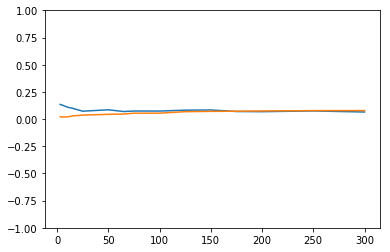

In [7]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# Plot it
for name, sil_scores in all_sil_scores.items():
    print(name)
    x, y = map(list, zip(*list(sil_scores.items())))
    ax = plt.gca()
    ax.set_ylim([-1, 1])
    plt.plot(x, y)
